# Machine Learning Engineer Nanodegree
## Project: Predicting article's retweets and favorites based on its title using Machine Learning

In this notebook is presented the code used to evaluate and test the assumptions of the prediction algorithm. The final report can be fully read on the attached file [final-report.pdf](https://github.com/flaviohenriquecbc/machine-learning-capstone-project/blob/master/final-report.pdf)

Choosing a good title for an article is an important step of the writing process. The more interesting the article title seems, the higher the chance a reader will interact with the whole content. This project focus on predicting the number of shares and favorites on Twitter from FreeCodeCamp's articles based on its titles. This problem is a classification task using  Supervised Learning. With data from FreeCodeCamp on Twitter and Medium, it was used machine learning methods including Support Vector Machines (SVM), Decision Trees, Gaussian Naive Bayes (GaussianNB), K-Nearest Neighbors and Logistic Regression to make the predictions.

## Exploring the Data
Load the FreeCodeCamp Twitter statistics and Medium statistics.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Import any additional functionality you may need here
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import re

from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier

sns.set_style('whitegrid')
sns.set_palette('coolwarm')

import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download()
from nltk.corpus import stopwords

print('Success')

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml
Success


In [2]:
# Read imported data
title_stat = pd.read_json("dataset/dataset-tweets-final.json", encoding='utf-8')
print("Title statistic data read successfully!")

Title statistic data read successfully!


### Data Exploration
Let's check how the dataset seems like. Some columns were ommited from this table (id, created_at and url)

The data used to predict how titles will perform was gathered from the accounts of the non-profit organization FreeCodeCamp on Medium and Twitter. On both social platforms, it was possible to get public information about how the users interacted with the content, using as “Favorites” and “Retweets” from Twitter, and “Claps” from Medium.

Correlating the number of “Favorites” and “Retweets” from Twitter with a Medium article, is an attempt to isolate the effect of number of reached readers and number of Medium “Claps”. Because the more the article is shared in different platforms, the more readers it will reach and the more Medium “Claps” it will receive. Using only the Twitter statistic, it is expected that the articles reached initially almost the same number of readers (that are the followers of the FreeCodeCamp account on Twitter), and their performance and interactions are limited to the characteristics of the tweet, for example, the title of the article, that is exactly what we want to measure.


In [3]:
#remove duplicates
title_stat = title_stat.drop_duplicates(subset=['text'], keep=False)
# Remove some columns to print
title_stat = title_stat.drop(['id', 'created_at', 'url'], axis=1)
# calculate length of the titles
title_stat['text_lenght'] = title_stat['text'].str.len()
# reorder the columns
title_stat = title_stat[title_stat.columns[[4, 0, 3, 2, 5, 1]]]
# rename the columns
temp = title_stat.rename(index=str, columns={"favorite_count": "Favorites (Twitter)", "medium_categories": "Categories (Medium)", "medium_claps": "Claps (Medium)", "retweet_count": "Retweet (Twitter)", "text": "Title (Twitter)", "text_lenght": "Title Length"})
title_stat = title_stat.rename(index=str, columns={"favorite_count": "Favorites", "medium_categories": "Categories", "medium_claps": "Claps", "retweet_count": "Retweet", "text": "Title", "text_lenght": "Title Length"})
# limit the total number of lines to print
temp.head()

,Title (Twitter),Favorites (Twitter),Retweet (Twitter),Claps (Medium),Title Length,Categories (Medium)
0,How to use JSON padding (and other options) to...,10,5,177,76,"[JavaScript, HTML, Web Development, Tutorial, ..."
1,How to build GitHub search functionality in Re...,19,7,61,90,"[React, Tech, Functional Programming, Programm..."
2,How to read and write Mindful Minutes from iOS...,11,6,54,93,"[iOS, Software Development, Programming, Web D..."
3,"How to make more money on Upwork, by @jpmorris",39,9,139,46,"[Freelancing, Tech, Web Development, Web Desig..."
4,Let's build a fun little game: Learn advanced ...,62,14,342,116,"[CSS, Games, Tech, Programming, React]"


### Exploratory Visualization

This section will explore the data visualization of the existing dataset and analyze the possible metrics that will be used to understand the solution. We will try to identify the relationship between each one of the features with the overall performance of the article. Within the following steps we will discuss:

* General statistic overview of the dataset
* Distribution of retweets, claps and favorites
* Relation of the title length with the performance of the article
* Relation of the article's categories with the performance of the article
* Relation of the article's words with the performance of the article
* Try to identify the relation between the features


#### Overall Statistics

We will analyze here the high level statistics of the articles. Try to understand how many times the articles were in average re-tweeted, clapped or marked as favorites. Also understand the average title length of the articles.

In [4]:
# calculate length of the titles
title_stat['Title Length'] = title_stat['Title'].str.len()
title_stat.describe()

,Favorites,Retweet,Claps,Title Length
count,711.000000,711.000000,711.000000,711.000000
mean,49.291139,16.438819,285.263010,80.624473
std,45.234113,15.685065,273.451934,22.190682
min,0.000000,0.000000,1.000000,21.000000
25%,20.000000,6.500000,7.500000,65.000000
50%,34.000000,11.000000,238.000000,80.000000
75%,63.500000,20.000000,471.500000,97.000000
max,298.000000,125.000000,997.000000,146.000000


From this statistic is possible to understand the order of magnitude of our dataset. Articles normally are re-tweeted and marked as favorite around tens of times and clapped hundreds of times. It is possible to check the maximum values from all the three variables, re-tweet and favorite hundreds and clap thousand of times. From these numbers we can define what is expected from our articles and the interaction with them. The length of the text goes from 21 to 146 characters, as expected, for a tweet content.

#### Histogram and Box plots

In this section we will check how the multiple features are distributed.

Total Retweet: 11688 times
Total Favorites: 35046 times
Total Claps: 202822 times


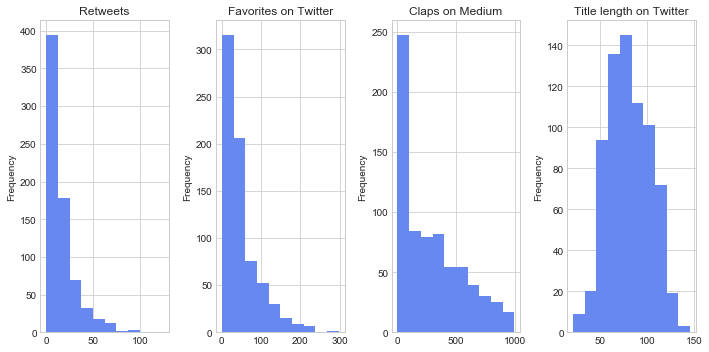

In [5]:
title_length = 'Title Length'
# set the columns that will show statistic and graph
columns = [{'column_name': 'Retweet', 'column_text': 'Retweets'},
           {'column_name': 'Favorites', 'column_text': 'Favorites on Twitter'},
           {'column_name': 'Claps', 'column_text': 'Claps on Medium'},
           {'column_name': title_length, 'column_text': 'Title length on Twitter'}] 

# plot histogram of columns
plt.figure(figsize=(10, 5))
for el in columns:
    class_name = el['column_name']
    column = title_stat[class_name]
    plt.subplot(1, 4, columns.index(el) + 1)
    plt.tight_layout()
    column.plot.hist(orientation='vertical', cumulative=False, title=el['column_text'])
    if class_name != title_length:
        print('Total {}: {} times'.format(class_name, column.sum()))

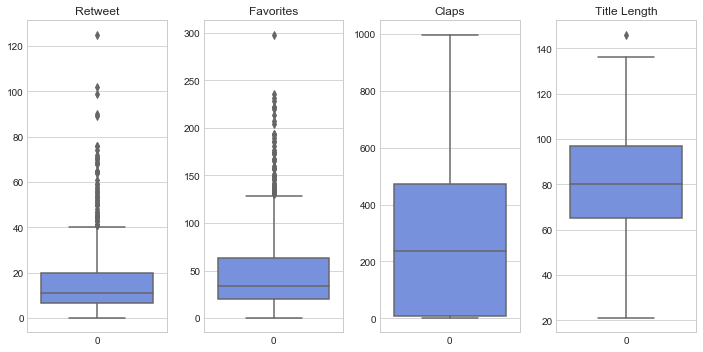

In [6]:
# plot boxplots
plt.figure(figsize=(10, 5))      
for el in columns:
    class_name = el['column_name']
    column = title_stat[class_name]
    plt.subplot(1, 4, columns.index(el) + 1)
    plt.tight_layout()
    plt.title(class_name);
    sns.boxplot(data=column);

From these histograms together with the overall statistic and the box plots, we can notice that we have a Gaussian distribution for the text length and the average length is around 80 characters. Favorite, re-tweet and claps are positive-skewed, i.e. they are concentrated on the left part of the graph, meaning that a small part of the articles will over-perform about readers' interaction and biggest part of them will generate less interaction.


#### Scatter Matrix

Here we try to find a relationship between the multiple features that we gathered from Twitter and Medium.


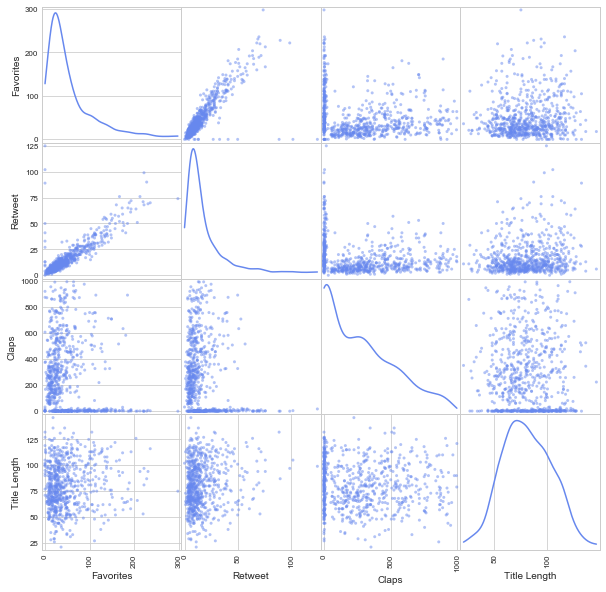

In [7]:
temp = pd.plotting.scatter_matrix(title_stat, diagonal="kde", figsize=(10, 10))

#### Title length that performed better

Here we analyze the relationship between the length of the title with its performance. For this experiment, we just considered the 25\% top performers of each feature.

In [8]:
# function to plot the top performers
PERCENTAGE = 25

In [9]:
# remove the outlier data ponts. We use the forumla:
# Outlier < Q_1 - 1.5* IQR
# Outlier > Q_3 + 1.5 * IQR
# Where Q_1 and Q_3 are the first and third quartile
# and IQR is the Interquartile Range (IQR = Q_3 - Q_1).
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    non_outliers = (df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)
#     non_outliers = df[column] >= 0
    return df.loc[non_outliers]

In [10]:
# plot relation between the number of retweet/favorite/claps and the title length or words in title
def plot_top_length_performers(col_name, is_grouped):
    plt.figure(figsize=(10, 5))      
    for el in columns:
        class_name = el['column_name']
        column = title_stat[class_name]
        if class_name != title_length:
            plt.subplot(1, 3, columns.index(el) + 1)
            plt.tight_layout()
            # remove outliers
            title_stat_top = remove_outliers(title_stat, class_name)
            # get top PERCENTAGE%
            title_stat_top = title_stat_top.sort_values(by=[class_name], ascending=False).head(int(len(title_stat)*(PERCENTAGE/100.00)))
            if (is_grouped):
                temp = title_stat_top.groupby(pd.cut(title_stat_top[col_name], bins=np.arange(0, 140+20, step=20))).mean()[class_name]
            else:
                temp = title_stat_top.groupby(title_stat_top[col_name]).mean()[class_name]
            temp.plot.bar()
            plt.title('{} vs {}'.format(el['column_text'], col_name));

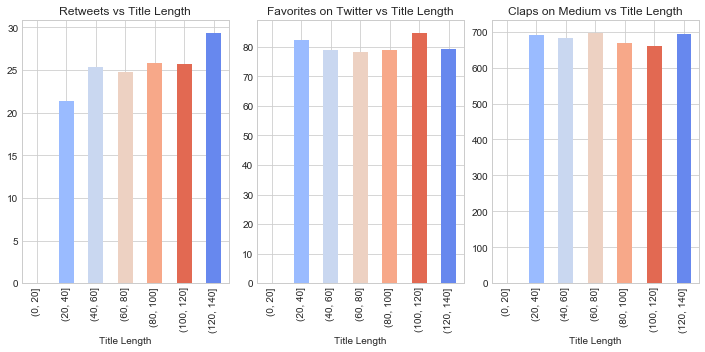

In [11]:
plot_top_length_performers(title_length, True)

To avoid being biased by outliers, we removed for each feature (favorites, re-tweets and claps) analysis the data points that don't fit the following formulas:

Outlier < Q_1 - 1.5* IQR

Outlier > Q_3 + 1.5 * IQR

Where Q_1 and Q_3 are the first and third quartile and IQR is the Interquartile Range (IQR = Q_3 - Q_1). 

We can notice from these graphics that longer titles tend to perform better than shorter ones for re-tweets, but for claps on Medium and favorites it seems to influence little.


#### Number of words in the title that performed better

After analyzing the title length and didn't reach any conclusion, we decided to investigate the number of words in the title.

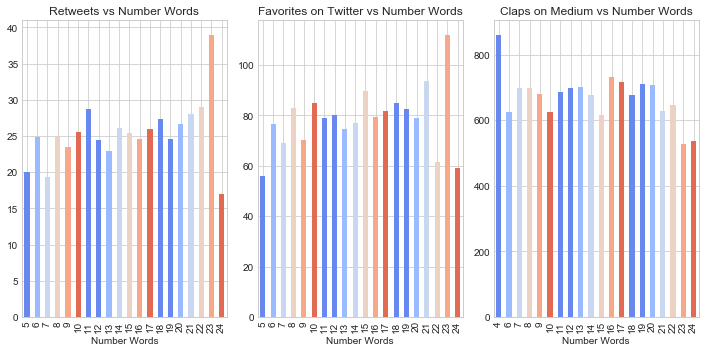

In [12]:
number_words = 'Number Words'
title_stat[number_words] = title_stat['Title'].str.split().apply(len)
plot_top_length_performers(number_words, False)

From this second experience showed on this image, we reached the conclusion that neither number of words on the title affect considerably its performance.

#### Categories that performed better

Here we filtered the dataset and just analyzed the top 25\% performers for each one of the features. We wanted to have a clear overview how the categories perform compared between them. The outliers were also removed here.

In [13]:
# plot relation between the words used on medium title and the number of retweet/favorite/claps. Just for the top PERCENTAGE% performers
def plot_top_performers(lst_col):
    for el in columns:
        column = title_stat[el['column_name']]
        class_name = el['column_name']
        if class_name != title_length:
            plt.figure(figsize=(10, 5))
            # remove outliers
            title_stat_top = remove_outliers(title_stat, class_name)
            title_stat_top = title_stat_top.sort_values(by=[class_name], ascending=False).head(int(len(title_stat_top)*(PERCENTAGE/100.00)))
            x = pd.DataFrame({
                    col:np.repeat(title_stat_top[col].values, title_stat_top[lst_col].str.len())
                    for col in title_stat_top.columns.difference([lst_col])
                }).assign(**{lst_col:np.concatenate(title_stat_top[lst_col].values)})[title_stat_top.columns.tolist()]
            temp = x.groupby(lst_col).count()[class_name].sort_values(ascending=False).head(20).sort_values(ascending=True)
            temp.plot.barh()
            plt.title('Most used {} on top {}% {}'.format(lst_col, PERCENTAGE, el['column_text']));

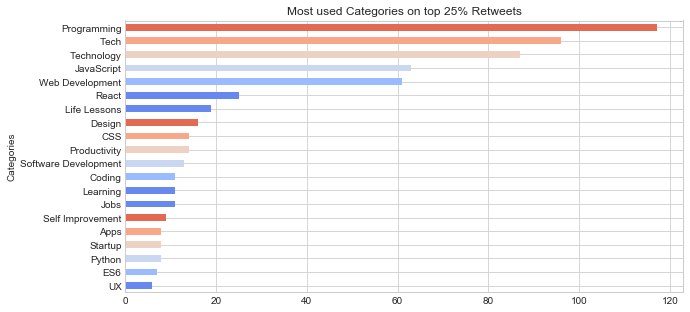

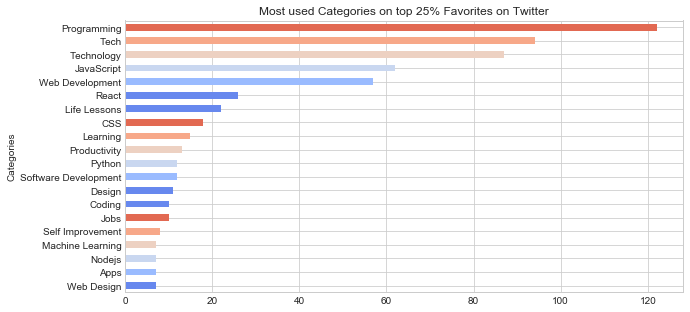

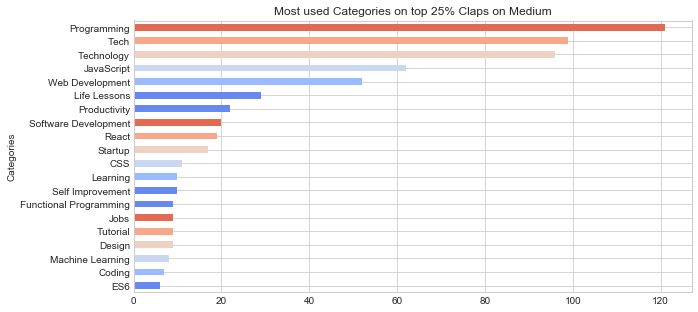

In [14]:
# plot relation between the tag used on medium (tag) and the number of retweet/favorite/claps
plot_top_performers('Categories')

From this statistic we notice that articles created with the following categories can increase the number of re-tweets, favorites and claps: "Programming", "Tech", "Technology", "JavaScript" and "Web Development".



#### Words that performed better

We repeated the same strategy of limiting the 25\% performers for the words on the title of the article. We wanted to understand if there are words that can boost the interaction from the readers. The outliers were also removed here.

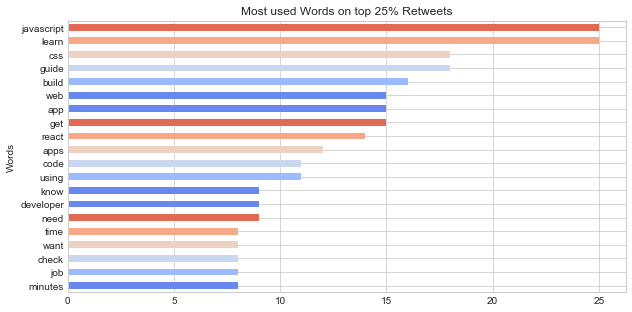

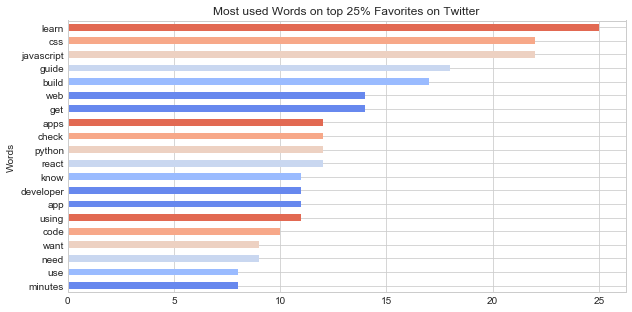

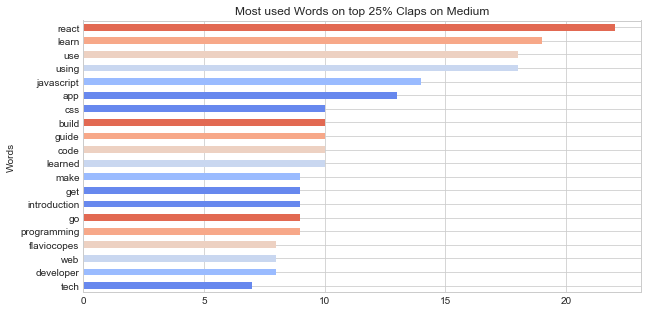

In [15]:
# create a column containing the words of the title
# remove special characters
temp = title_stat['Title'].str.lower().str.translate(str.maketrans('','','()!@#$:"?,./+')).str.split()
# temp = title_stat['Title'].str.lower().str.split()
# remove common words (it, a, the, ...)
stop=set(stopwords.words('english'))
title_stat['Words'] = temp.apply(lambda x: [item for item in x if item not in stop and not '\\' in item])
# title_stat['Words'] = temp
# print(stop) #uncomment to see removed words
# plot relation between the words used on medium title and the number of retweet/favorite/claps. Just for the top PERCENTAGE% performers
plot_top_performers('Words')

In this lexical analysis, we can notice that some words get much more attention on the FreeCodeCamp community than others, we noticed if we want to make our articles reach further in numbers talking about XXX, XXX, XXXX will increase this change.

## Methodology

### Data Preprocessing

The first part of the data processing was to clean the dataset. For 



In [16]:
def get_category_name(column_name):
    return '{} Category'.format(column_name)

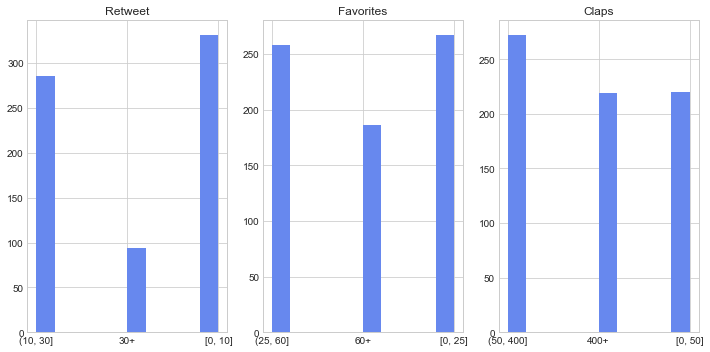

In [32]:
def get_range(value, ranges):
    for idx,max_value in enumerate(ranges):
        if value <= max_value:
            previous = '({}'.format(ranges[idx-1]) if idx >= 1 else '[0'
            return '{}, {}]'.format(previous, max_value)
    return '{}+'.format(ranges[-1])

# plot histogram of columns
plt.figure(figsize=(10, 5))
for el in columns:
    class_name = el['column_name']
    if class_name != title_length:
        column = title_stat[class_name]
        plt.subplot(1, 3, columns.index(el) + 1)
        plt.tight_layout()
        ranges = {
            'Retweet': [10, 30],
            'Favorites': [25, 60],
            'Claps': [50, 400]
        }
        column = [ get_range(a, ranges[class_name]) for a in column ]
        plt.title('{}'.format(class_name))
        pd.DataFrame(column)[0].hist(xrot=0)
        
        # add classification to dataframe
        title_stat[get_category_name(class_name)] = column

### Implementation

...

..


In [33]:
# clean the title
def clean_text(text):
    # remove twitter users, leave @ for stats reason
    text = text.map(lambda x: re.sub('@[_A-Za-z0-9]+','@',str(x)))
    # remove wrong convertion characters from title
    text = text.map(lambda x: re.sub(r'\\x[00-ff]{2}','',str(x)))
    text = text.str.strip()
    return text

def split_data(title_stat, class_name, is_remove_outlier, is_clean_text):
            # remove outliers
            if is_remove_outlier:
                title_stat_top = remove_outliers(title_stat, class_name)
            else:
                title_stat_top = title_stat
                
            # Set the number of testing points
            if is_clean_text:
                X_all = clean_text(title_stat_top['Title'])
            else:
                X_all = title_stat_top['Title']
            y_all = title_stat_top[get_category_name(class_name)]

            # Shuffle and split the dataset into the number of training and testing points above
            X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=ratios[class_name], shuffle=False)
        
            return {
                'title_stat_top': title_stat_top,
                'X_all': X_all,
                'y_all': y_all,
                'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_test': y_test
            }

In [34]:
X_all = {}
y_all = {}
X_train = {}
X_test = {}
y_train = {}
y_test = {}

ratios = {
    'Retweet': 0.2,
    'Favorites': 0.2,
    'Claps': 0.2
}

for el in columns:
    column = title_stat[el['column_name']]
    class_name = el['column_name']
    if class_name != title_length:
        values = split_data(title_stat, class_name, True, True)
        title_stat_top, X_all[class_name], y_all[class_name], X_train[class_name], X_test[class_name], y_train[class_name], y_test[class_name] = [values[k] for k in ('title_stat_top', 'X_all','y_all', 'X_train', 'X_test', 'y_train', 'y_test')]
        
        total = title_stat[class_name].count()
        total_no_outliers = title_stat_top[class_name].count()
        print('{}\nTotal: {} items.\nTotal without outliers: {}'.format(class_name, total, total_no_outliers))
        
        # Show the results of the split
        print("Training set has {} samples".format(X_train[class_name].shape[0]))
        print("Testing set has {} samples\n".format(X_test[class_name].shape[0]))

Retweet
Total: 711 items.
Total without outliers: 658
Training set has 526 samples
Testing set has 132 samples

Favorites
Total: 711 items.
Total without outliers: 658
Training set has 526 samples
Testing set has 132 samples

Claps
Total: 711 items.
Total without outliers: 711
Training set has 568 samples
Testing set has 143 samples



In [35]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import FunctionTransformer

# implement bag of words with td-idf
X_train_word_features = {}
test_features = {}

def get_text_length(x):
    return np.array([len(t) for t in x]).reshape(-1, 1)

def get_words_length(x):
    return np.array([len(t.split()) for t in x]).reshape(-1, 1)

def to_array(x):
    return x.toarray()

In [36]:
# load classifiers
# Initialize the models
# for each classifier was defined (code bellow: Best features) the best parameters for each feature
# if the best parameters calculated for the model is the same as default, i will mark as #DEFAULT
classifiers = [
    # no parameter to test for the model GaussianNB()
    {
        'classifier': GaussianNB(),
        'toarray': True,
        'parameters': {}
    },
    {
        'classifier': LogisticRegression(),
        'toarray': False,
        'parameters': {
            'C': [0.1, 0.5, 1, 2, 10],
            'fit_intercept': [True, False],
            'class_weight': ['balanced', None],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
            'max_iter': [10, 100, 300]
        }
    },
    {
        'classifier': DecisionTreeClassifier(),
        'toarray': False,
        'parameters': {
            'splitter': ['random', 'best'],
            'max_depth': [1, 5, 10, 20, None],
            'class_weight': ['balanced', None]
        }
    },
    {
        'classifier': SVC(),
        'toarray': True,
        'parameters': {
            'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
            'degree':[1, 2, 3, 4, 5, 6, 7],
            'C':[0.5, 1, 2],
        }
    },
    {
        'classifier': KNeighborsClassifier(),
        'toarray': False,
        'parameters': {
            'n_neighbors': [1, 5, 10, 15, 20, 30], 
            'weights': ['distance', 'uniform'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': [10, 30, 50],
        }
    },
    {
        'classifier': MultinomialNB(),
        'toarray': False,
        'parameters': {
                'alpha': [0, 0.5, 1],
                'fit_prior': [True, False]
        }
    },
    {
        'classifier': GradientBoostingClassifier(),
        'toarray': False,
        'parameters': {
            'learning_rate': [0.1, 0.5, 1.0],
            'loss': ['deviance'],
            'max_depth': [3, 5, 10],
            'max_features': [None],
            'min_samples_leaf': [1, 2],
            'min_samples_split': [0.1, 0.5, 1.0],
            'min_weight_fraction_leaf': [0.0],
            'n_estimators': [50, 100],
            'random_state': [0, None],
            'subsample': [1.0],
            'warm_start': [False]
        }
    }
]

In [37]:
from sklearn.metrics import accuracy_score

def get_score_pipeline(classifier_algo, X_train, y_train):
    classifier = Pipeline([
        ('features', FeatureUnion([
            ('text', Pipeline([
                ('vectorizer', TfidfVectorizer(#TfidfVectorizer#CountVectorizer
                                    stop_words='english',
                                    strip_accents='unicode',
                                    token_pattern=r'\w{1,}',
                                    analyzer='word',
                                    ngram_range=(1, 1),
                                )),
                ('toarray', Pipeline([
                    ('count', FunctionTransformer(to_array, validate=False)),
                ]))
            ])),
            ('length', Pipeline([
                ('count', FunctionTransformer(get_text_length, validate=False)),
            ])),
            ('size', Pipeline([
                ('count', FunctionTransformer(get_words_length, validate=False)),
            ]))
        ])),
        ('clf', OneVsRestClassifier(classifier_algo))])

    cv_score = np.mean(cross_val_score(classifier, X_train, y_train, cv=5, scoring='accuracy'))
    print('\t\tAccuracy score: {}'.format(cv_score))
    return cv_score

def get_score(classifier_algo, X_train, X_test, y_train, y_test, name, is_td_idf=True, is_stop_word=True):
    tokens = tokenize(X_train, X_test, is_td_idf, is_stop_word)
    _X_train = tokens['X_train']
    _X_test = tokens['X_test']

    # fit model
    classifier_algo.fit(_X_train, y_train)
    # predict
    y_pred = classifier_algo.predict(_X_test)
    # measure
    cv_score = accuracy_score(y_test, y_pred)
    print('\t\tAccuracy score ({}): {}'.format(name, cv_score))
    return cv_score

def set_statistic_score(class_name, cv_score, model_name, accuracy, classifier_name):
    # store value, if better than others
    if class_name not in accuracy or accuracy[class_name] < cv_score:
        accuracy[class_name] = cv_score
        classifier_name[class_name] = model_name

def print_complete_stat(X_train, X_test, y_train, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(X_test, y_test))
    
def tokenize(X_train, X_test, is_td_idf=True, is_stop_word=True):
    #TfidfVectorizer#CountVectorizer
    if is_td_idf:
        tokenizr = TfidfVectorizer
    else:
        tokenizr = CountVectorizer
    
    if is_stop_word:
        stop_words='english'
    else:
        stop_words=None
        
    word_vectorizer = tokenizr(
                        stop_words=stop_words,
                        strip_accents='unicode',
                        token_pattern=r'\w{1,}',
                        analyzer='word',
                        ngram_range=(1, 1))

    word_vectorizer.fit(X_train)
    _X_train = word_vectorizer.transform(X_train)
    _X_train = np.append(_X_train.todense(), get_text_length(X_train), 1)
    _X_train = np.append(_X_train, get_words_length(X_train), 1)
    _X_test = word_vectorizer.transform(X_test)
    _X_test = np.append(_X_test.todense(), get_text_length(X_test), 1)
    _X_test = np.append(_X_test, get_words_length(X_test), 1)
    return {
        'X_train': _X_train,
        'X_test': _X_test
    }

def set_score_stat(classifier_algo, class_name, X_train, X_test, y_train, y_test, accuracy, classifier_name, is_default):
    name_type = 'default' if is_default else 'optimized'
    name = '{} ({})'.format(classifier_algo.__class__.__name__, name_type)
    # cv_score = get_score_pipeline(classifier_algo, X_all[class_name], y_all[class_name])
    cv_score = get_score(classifier_algo, X_train, X_test, y_train, y_test, name_type)
    # store value, if better than others
    set_statistic_score(class_name, cv_score, name, accuracy, classifier_name)

In [38]:
# run the models with the parameters defined and check with has better accuracy
# this method just run the default model for each data set
# Use the method bellow (Looking for: Best features), for a deeper analysis
classifier_name = {}
accuracy = {}
for clf in classifiers:
    print("==== Classifier: {} ====".format(clf['classifier'].__class__.__name__))
    for el in columns:
        column = title_stat[el['column_name']]
        class_name = el['column_name']
        if class_name != title_length:
            name = 'classifier-{}'.format(class_name)
            # if there is a specific model refined, use it
            classifier_algo = clf[name] if name in clf else clf['classifier']
            print('\t==== {} ===='.format(class_name))

            # calculate score and add to statistic
            set_score_stat(classifier_algo, class_name, X_train[class_name], X_test[class_name], y_train[class_name], y_test[class_name], accuracy, classifier_name, True)

            # print_complete_stat(X_train[class_name], X_test[class_name], y_train[class_name], y_test[class_name])
        
print('Best scores:')
print(accuracy)
print(classifier_name)

==== Classifier: GaussianNB ====
	==== Retweet ====
		Accuracy score (default): 0.49242424242424243
	==== Favorites ====
		Accuracy score (default): 0.4621212121212121
	==== Claps ====
		Accuracy score (default): 0.4125874125874126
==== Classifier: LogisticRegression ====
	==== Retweet ====
		Accuracy score (default): 0.5909090909090909
	==== Favorites ====
		Accuracy score (default): 0.45454545454545453
	==== Claps ====
		Accuracy score (default): 0.46853146853146854
==== Classifier: DecisionTreeClassifier ====
	==== Retweet ====
		Accuracy score (default): 0.5151515151515151
	==== Favorites ====
		Accuracy score (default): 0.5
	==== Claps ====
		Accuracy score (default): 0.38461538461538464
==== Classifier: SVC ====
	==== Retweet ====
		Accuracy score (default): 0.553030303030303
	==== Favorites ====
		Accuracy score (default): 0.4696969696969697
	==== Claps ====
		Accuracy score (default): 0.4195804195804196
==== Classifier: KNeighborsClassifier ====
	==== Retweet ====
		Accuracy sc

In [193]:
from sklearn.grid_search import GridSearchCV 
from sklearn.metrics import make_scorer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack

# Looking for: Best features
# Fine tune the chosen model. Using grid search (GridSearchCV) with at least one
# important parameter tuned with at least 3 different values.
# You will need to use the entire training set for this. In the code cell below, you will need to implement the following:

accuracy = {}
classifier_name = {}
for classifier in classifiers:
    for el in columns:
    #     el = {'column_name': 'Retweet', 'column_text': 'Retweets'}
    #     el = {'column_name': 'Favorites', 'column_text': 'Favorites on Twitter'}
    #     el = {'column_name': 'Claps', 'column_text': 'Claps on Medium'}
        column = title_stat[el['column_name']]
        class_name = el['column_name']
        clf = classifier['classifier']
        parameters = classifier['parameters']
        print("==== Classifier: {} ====".format(clf.__class__.__name__))
        if class_name != title_length:
            print('\t==== {} ===='.format(class_name))
            
            # calculate score and add to statistic
            set_score_stat(classifier_algo, class_name,
                            X_train[class_name], X_test[class_name],
                           y_train[class_name], y_test[class_name].values,
                           accuracy, classifier_name, True)

            # Grid search on the classifier using the f1_scorer as the scoring method
            grid_obj = GridSearchCV(clf, param_grid = parameters, scoring=make_scorer(accuracy_score))
            
            tokens = tokenize(X_train[class_name], X_test[class_name])
            _X_train = tokens['X_train']

            # Fit the grid search object to the training data and find the optimal parameters
            import warnings; warnings.simplefilter('ignore')
            grid_obj = grid_obj.fit(_X_train, y_train[class_name])

            # Get the estimator
            print('Model best estimator: {}'.format(grid_obj.best_estimator_))

            # calculate score and add to statistic
            classifier_algo = grid_obj.best_estimator_
            set_score_stat(classifier_algo, class_name,
                            X_train[class_name], X_test[class_name],
                           y_train[class_name], y_test[class_name].values, accuracy, classifier_name, False)

==== Classifier: GaussianNB ====
	==== Retweet ====
		Accuracy score (default): 0.5909090909090909
Model best estimator: GaussianNB(priors=None)
		Accuracy score (optimized): 0.49242424242424243
==== Classifier: GaussianNB ====
	==== Favorites ====
		Accuracy score (default): 0.4621212121212121
Model best estimator: GaussianNB(priors=None)
		Accuracy score (optimized): 0.4621212121212121
==== Classifier: GaussianNB ====
	==== Claps ====
		Accuracy score (default): 0.4125874125874126
Model best estimator: GaussianNB(priors=None)
		Accuracy score (optimized): 0.4125874125874126
==== Classifier: GaussianNB ====
==== Classifier: LogisticRegression ====
	==== Retweet ====
		Accuracy score (default): 0.49242424242424243
Model best estimator: LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=



### Conclusion

...

..

In [331]:
# Plot for the winners the hit and lost points
models_winners = {
    'Retweet': MultinomialNB(alpha=1, class_prior=None, fit_prior=True),
    'Favorites': LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=False, intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2', random_state=None, solver='lbfgs', tol=0.0001, verbose=0, warm_start=False),
    'Claps': LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=10, multi_class='ovr', n_jobs=1, penalty='l2', random_state=None, solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
}

info = {}
for el in columns:
    column = title_stat[el['column_name']]
    class_name = el['column_name']
    acc = []
    if class_name != title_length:
        print('\t==== {} ===='.format(class_name))

        # how evolved the refinement of the solution
        configurations = [
            {'is_remove_outlier': False, 'is_clean_text': False, 'is_td_idf': False, 'is_stop_word':  False, 'title': 'Benchmark', 'tag': 'benchmark', 'model_winner': False},
            {'is_remove_outlier': False, 'is_clean_text': False, 'is_td_idf': False, 'is_stop_word':  False, 'title': 'Parameters tuned', 'tag': 't1', 'model_winner': True},
            {'is_remove_outlier': True, 'is_clean_text': False, 'is_td_idf': False, 'is_stop_word':  False, 'title': 'Parameters tuned + no outlier', 'tag': 't2', 'model_winner': True},
            {'is_remove_outlier': True, 'is_clean_text': True, 'is_td_idf': False, 'is_stop_word':  False, 'title': 'Parameters tuned + no outlier + clean words', 'tag': 't3', 'model_winner': True},
            {'is_remove_outlier': True, 'is_clean_text': True, 'is_td_idf': True, 'is_stop_word':  False, 'title': 'Parameters tuned + no outlier + clean words + td-idf', 'tag': 't4', 'model_winner': True},
            {'is_remove_outlier': True, 'is_clean_text': True, 'is_td_idf': True, 'is_stop_word':  True, 'title': 'Winner model = Parameter tuned + no outliers + clean words + stopwords + td-idf', 'tag': 'winner', 'model_winner': True},
        ]

        for c in configurations:
            # run for the benchmark
            print(c['title'])
            classifier_algo = models_winners[class_name] if c['model_winner'] else LogisticRegression()
            values = split_data(title_stat, class_name, c['is_remove_outlier'], c['is_clean_text'])
            title_stat_top2, X2_all, y2_all, X2_train, X2_test, y2_train, y2_test = [values[k] for k in ('title_stat_top', 'X_all','y_all', 'X_train', 'X_test', 'y_train', 'y_test')]
            acc.append(get_score(classifier_algo, X2_train, X2_test, y2_train, y2_test, c['tag'], c['is_td_idf'], c['is_stop_word']))

        info[class_name] = pd.DataFrame({
            'evolution': ['benchmark', 't1', 't2', 't3', 't4', 'winner'], 
            'accuracy': list(map(lambda x: 100*x, acc))
        })
        

	==== Retweet ====
Benchmark
		Accuracy score (benchmark): 0.5734265734265734
Parameters tuned
		Accuracy score (t1): 0.5524475524475524
Parameters tuned + no outlier
		Accuracy score (t2): 0.5909090909090909
Parameters tuned + no outlier + clean words
		Accuracy score (t3): 0.5681818181818182
Parameters tuned + no outlier + clean words + td-idf
		Accuracy score (t4): 0.5606060606060606
Winner model = Parameter tuned + no outliers + clean words + stopwords + td-idf
		Accuracy score (winner): 0.6060606060606061
	==== Favorites ====
Benchmark
		Accuracy score (benchmark): 0.5314685314685315
Parameters tuned
		Accuracy score (t1): 0.5174825174825175
Parameters tuned + no outlier
		Accuracy score (t2): 0.49242424242424243
Parameters tuned + no outlier + clean words
		Accuracy score (t3): 0.5075757575757576
Parameters tuned + no outlier + clean words + td-idf
		Accuracy score (t4): 0.5151515151515151
Winner model = Parameter tuned + no outliers + clean words + stopwords + td-idf
		Accuracy 

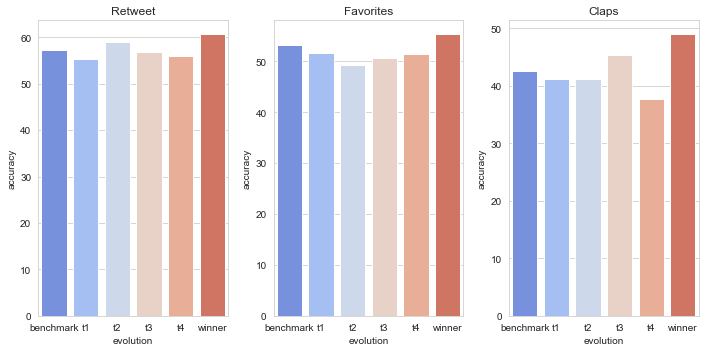

In [348]:
plt.figure(figsize=(10, 5))
for el in columns:
    class_name = el['column_name']
    if class_name != title_length:
        plt.subplot(1, 3, columns.index(el) + 1)
        plt.tight_layout()
        plt.title(class_name);
        values = info[class_name]
        sns.barplot(values['evolution'], values['accuracy'])
